In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import transformers

print(transformers.__version__)

In [3]:
squad_v2 = True
model_checkpoint = "distilbert-base-uncased"
batch_size = 32

## Loading the dataset

In [4]:
from datasets import load_dataset, load_metric

In [5]:
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

In [6]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [7]:
datasets["train"][0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [8]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,572fdefc04bcaa1900d76e15,Premier_League,"In 2011, a Welsh club participated in the Premier League for the first time after Swansea City gained promotion. The first Premier League match to be played outside England was Swansea City's home match at the Liberty Stadium against Wigan Athletic on 20 August 2011. In 2012–13, Swansea qualified for the Europa League by winning the League Cup. The number of Welsh clubs in the Premier League increased to two for the first time in 2013–14, as Cardiff City gained promotion, but Cardiff City was relegated after its maiden season.",When was Swansea City's home match played against Wigan Athletic?,"{'text': ['Swansea City's home match at the Liberty Stadium against Wigan Athletic on 20 August 2011.'], 'answer_start': [177]}"
1,5a8cccd9fd22b3001a8d8e9c,FA_Cup,"In the early years of coverage the BBC had exclusive radio coverage with a picture of the pitch marked in the Radio Times with numbered squares to help the listener follow the match on the radio. The first FA Cup Final on Radio was in 1926 between Bolton Wanderers and Manchester City but this was only broadcast in Manchester, the first national final on BBC Radio was between Arsenal and Cardiff in 1927. The first final on BBC Television was in 1937 in a match which featured Sunderland and Preston North End but this was not televised in full. The following season's final between Preston and Huddersfield was covered in full by the BBC. When ITV was formed in 1955 they shared final coverage with the BBC in one of the only club matches shown live on television, during the 1970s and 1980s coverage became more elaborate with BBC and ITV trying to steal viewers from the others by starting coverage earlier and earlier some starting as early as 9 a.m. which was six hours before kick off. Nowadays, this continues with Setanta and ESPN having all-day broadcasts from Wembley, but terrestrial TV coverage usually begins two hours before kick off. The sharing of rights between BBC and ITV continued from 1955 to 1988, when ITV lost coverage to the new Sports Channel which later became Sky Sports.",How long does coverage continue after kick off?,"{'text': [], 'answer_start': []}"
2,5ad16b34645df0001a2d1a88,Electric_motor,"Stepper motors were and still are often used in computer printers, optical scanners, and digital photocopiers to move the optical scanning element, the print head carriage (of dot matrix and inkjet printers), and the platen or feed rollers. Likewise, many computer plotters (which since the early 1990s have been replaced with large-format inkjet and laser printers) used rotary stepper motors for pen and platen movement; the typical alternatives here were either linear stepper motors or servomotors with closed-loop analog control systems.","In printers and copiers, what don't stepper motors move?","{'text': [], 'answer_start': []}"
3,5a8cb299fd22b3001a8d8d60,Biodiversity,"In absolute terms, the planet has lost 52% of its biodiversity since 1970 according to a 2014 study by the World Wildlife Fund. The Living Planet Report 2014 claims that ""the number of mammals, birds, reptiles, amphibians and fish across the globe is, on average, about half the size it was 40 years ago"". Of that number, 39% accounts for the terrestrial wildlife gone, 39% for the marine wildlife gone, and 76% for the freshwater wildlife gone. Biodiversity took the biggest hit in Latin America, plummeting 83 percent. High-income countries showed a 10% increase in biodiversity, which was canceled out by a loss in low-income countries. This is despite the fact that high-income countries use five times the ecological resources of low-income countries, which was explained as a result of process whereby wealthy nations are outsourcing resource depletion to poorer nations, which are suffering the greatest ecosystem losses.",What percentage accounts for the Latin America freshwater wildlife gone?,"{'text': [], 'answer_start': []}"
4,5731932

## Preprocessing the training data

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [11]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [12]:
tokenizer("What is your name?", "My name is Minhah.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 19538, 4430, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [14]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

In [15]:
len(tokenizer(example["question"], example["context"])["input_ids"])

437

In [16]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

In [17]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [18]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 192]

In [19]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

In [20]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

In [21]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

In [22]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

In [23]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

In [24]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

In [25]:
pad_on_right = tokenizer.padding_side == "right"

In [26]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [27]:
features = prepare_train_features(datasets['train'][:5])

In [28]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

## Fine-tuning the model

In [29]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=True,
)

In [31]:
from transformers import default_data_collator

data_collator = default_data_collator

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [33]:
trainer.train()

/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,1.238500,1.232192
2,0.916600,1.271155
3,0.679100,1.337724
4,0.507500,1.559329
5,0.383400,1.832681


/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was a

TrainOutput(global_step=10295, training_loss=0.8025345619353581, metrics={'train_runtime': 5274.7608, 'train_samples_per_second': 124.891, 'train_steps_per_second': 1.952, 'total_flos': 6.455275703106048e+16, 'train_loss': 0.8025345619353581, 'epoch': 5.0})

In [34]:
trainer.save_model("test-squad-trained")

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1699268002.a100.244162.0:   0%|          | 0.00/9.00k [00:00<?, ?B/s]

## Evaluation

In [35]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [36]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([64, 384]), torch.Size([64, 384]))

In [37]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 49,  37,  72,  80, 157,  17,  44,  99, 152, 202, 119,  42,  22,  31,
           0, 120, 252,  94,  90,   0,  37,  56,  88, 152,   0,   0,   0, 138,
           0,   0,   0,  23,  71,  32,  51,  76,  93,  15,  94, 105,  40,  13,
          33,  55,  99,  29,  80, 136,  28,   0,   0,  79,  65,  70,  26,  13,
          48,  62,  75,   0,  16,   0,   0,  12], device='cuda:0'),
 tensor([ 49,  40,  76,  81, 157,  19,  44, 101, 153, 204, 120,  53,  26,  33,
           0, 121, 252,  98,  91,   0,  91,  56,   0, 153,   0,   0,   0, 142,
           0,   0,   0,  23,  72,  35,  51,  76,  94,  27,  94, 106,  44,  15,
          36,  56, 104,  30,  81,   0,  29,   0,   0,  80,  66,  71,  26,  68,
          49,  63,  82,   0,  17,   0,   0,  15], device='cuda:0'))

In [38]:
n_best_size = 20

In [39]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [40]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [41]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [42]:
raw_predictions = trainer.predict(validation_features)

In [43]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [44]:
max_answer_length = 30

In [45]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 18.266037, 'text': 'France'},
 {'score': 10.566034, 'text': 'France.'},
 {'score': 6.698577, 'text': 'in France'},
 {'score': 6.493479,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark'},
 {'score': 6.12866, 'text': 'a region in France'},
 {'score': 5.5263367, 'text': 'Normandy, a region in France'},
 {'score': 4.7002873, 'text': 'region in France'},
 {'score': 4.401839,
  'text': 'in the 10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 3.047008,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'},
 {'score': 2.4326286, 'text': ', a region in France'},
 {'score': 1.6284661,
  'text': '10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 1.5413232,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from De

In [46]:
datasets["validation"][0]["answers"]

{'text': ['France', 'France', 'France', 'France'],
 'answer_start': [159, 159, 159, 159]}

In [47]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [48]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [49]:
final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

  0%|          | 0/11873 [00:00<?, ?it/s]

In [50]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

/tmp/ipykernel_244162/2905994612.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if squad_v2 else "squad")


In [51]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 65.29941884949044,
 'f1': 68.9549015270834,
 'total': 11873,
 'HasAns_exact': 66.73414304993253,
 'HasAns_f1': 74.05559140200049,
 'HasAns_total': 5928,
 'NoAns_exact': 63.86879730866274,
 'NoAns_f1': 63.86879730866274,
 'NoAns_total': 5945,
 'best_exact': 65.29941884949044,
 'best_exact_thresh': 0.0,
 'best_f1': 68.95490152708359,
 'best_f1_thresh': 0.0}

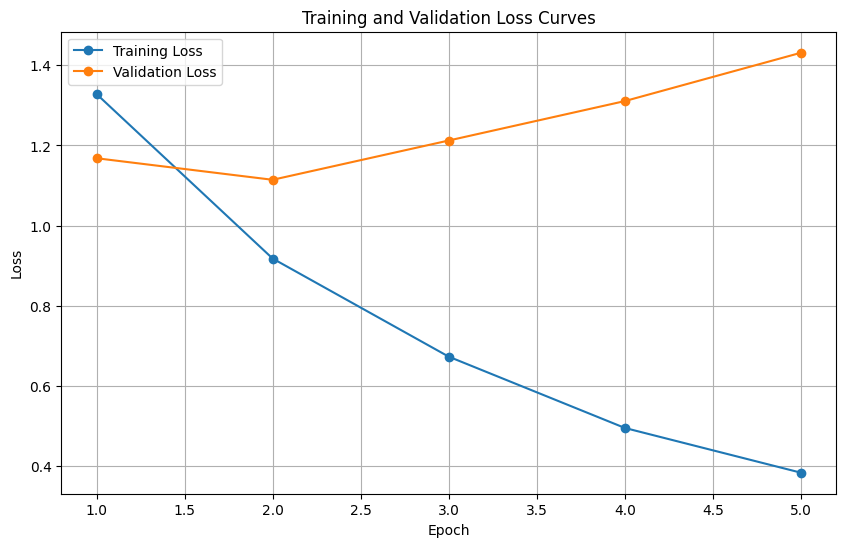

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with your data
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Training Loss': [1.328300, 0.917900, 0.673100, 0.495300, 0.383700],
    'Validation Loss': [1.168076, 1.114305, 1.212297, 1.310670, 1.431227]
}

df = pd.DataFrame(data)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss', marker='o')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='o')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Show the plot
plt.grid()
plt.show()
